This final project will be a "choose your own deep learning adventure." There are multiple reasons for this:

### Assignment Specs
1. "Deep Learning" encompasses too many different methods for us to cover in our last two weeks of the term. So, giving you the choice should help maximize what you get out of the last two weeks of our class.
2. Opening this project now and giving you the choice means that you don't have to wait for me to cover anything in class before starting work

There are some constraints to the adventure you choose in order to give the projects some structure and consistency:

1. Create two of your own **"NEW"** keras code examples that could, theoretically, be added here: https://keras.io/examples/ to an external site. . You do NOT need to follow their posted "rules" for this, but you should try to:
- Shorter than 300 lines of code if you can (this does not include data wrangling and pre-processing).
    - Comments and explanatory text may be as long as you want!!!
- It should demonstrate modern keras/TensorFlow best practices (your approach and code style should mimic the other examples posted).
- **You do not need to create anything from scratch. In fact, you should feel free to pick two of the examples at this site to recreate with at least the following differences:**
    - A new dataset
    - Improved narrative text
- **Your choice of topic should be informed by the following goal:**
    - **Pitch deep learning as a business analytics tool**
    - Common areas of application include:
        - Image recognition
        - Natural language processing
        - Customer relationship management
        - Recommendation systems
        - Bioinformatics
        - Medical image analysis
        - Financial fraud detection
- It should be well documented and commented.
- <u>Your resulting submission should be understandable by a student who has just finished GSB 544.</u>
- You should be running this example yourself to confirm that it is accessible to people new to this content.
- Your submission should be a single notebook/file for each example selected.
While you may technically choose to pursue a project involving any neural network-related models, I would strongly encourage you to explore models and/or tasks that we did NOT discuss in the first 8 weeks of our course.

### Notes:
Deep Learning:
- A class of machine learning algorithms that uses multiple layers to progressively extract higher-level features from the raw input

Autoencoder:
- A specific type of feedmforward neural network where the input is the same as the output
- They compress the input into a lower-dimensional code and then reconstruct the output from this representation
- Consists of 3 components:
1. encoder
2. code
3. decoder

^ Mainly a dimensionality reduction (or compression) algorithm
- Data-specific: only really able to meaningfully compress data similar to what they have been trained on
- It’s not fully lossless: output will not be exactly the same as the input
- Unsupervised (self-supervised)
- Usually use mean squared error or cross entropy as the loss function

## Demand Forecasting with ERP System
*Data:* [Favorita Grocery Sales](https://www.kaggle.com/competitions/favorita-grocery-sales-forecasting/data)

In [4]:
import pandas as pd
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Bidirectional

In [5]:
train = pd.read_csv('/Users/dan/calpoly/BusinessAnalytics/GSB545ADML/Week9/Favorita/train.csv')
stores = pd.read_csv("/Users/dan/calpoly/BusinessAnalytics/GSB545ADML/Week9/Favorita/stores.csv")
items = pd.read_csv("/Users/dan/calpoly/BusinessAnalytics/GSB545ADML/Week9/Favorita/items.csv")

/var/folders/jl/kkh608tn0k194f6cv0bwbqp80000gn/T/ipykernel_4573/3533856664.py:1: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  train = pd.read_csv('/Users/dan/calpoly/BusinessAnalytics/GSB545ADML/Week9/Favorita/train.csv')


In [33]:
train.head()

,id,date,store_nbr,item_nbr,unit_sales,onpromotion
0,0,2013-01-01,25,103665,7.0,NaN
1,1,2013-01-01,25,105574,1.0,NaN
2,2,2013-01-01,25,105575,2.0,NaN
3,3,2013-01-01,25,108079,1.0,NaN
4,4,2013-01-01,25,108701,1.0,NaN


#### Clean Data

- Remove NaN values
- Logarithmic scale on sales for target variable
- Add categorical data for the day of the week, month, and year
- Add binary variable for is_weekend
- Merge othe two datasets in ERP system to increase inputs for better prediction.


In [6]:
train["onpromotion"] = train["onpromotion"].fillna(False)
train["unit_sales"] = train["unit_sales"].clip(lower=0)
train["log_sales"] = np.log1p(train["unit_sales"])
train["date"] = pd.to_datetime(train["date"], errors="coerce")
train["dayofweek"] = train["date"].dt.dayofweek
train["month"] = train["date"].dt.month
train["year"] = train["date"].dt.year
train["is_weekend"] = train["dayofweek"].isin([5, 6])

train = train.merge(items, on="item_nbr", how="left")
train = train.merge(stores, on="store_nbr", how="left")

/var/folders/jl/kkh608tn0k194f6cv0bwbqp80000gn/T/ipykernel_4573/1656104518.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train["onpromotion"] = train["onpromotion"].fillna(False)


In [7]:
train.head()

,id,date,store_nbr,item_nbr,unit_sales,onpromotion,log_sales,dayofweek,month,year,is_weekend,family,class,perishable,city,state,type,cluster
0,0,2013-01-01,25,103665,7.0,False,2.079442,1,1,2013,False,BREAD/BAKERY,2712,1,Salinas,Santa Elena,D,1
1,1,2013-01-01,25,105574,1.0,False,0.693147,1,1,2013,False,GROCERY I,1045,0,Salinas,Santa Elena,D,1
2,2,2013-01-01,25,105575,2.0,False,1.098612,1,1,2013,False,GROCERY I,1045,0,Salinas,Santa Elena,D,1
3,3,2013-01-01,25,108079,1.0,False,0.693147,1,1,2013,False,GROCERY I,1030,0,Salinas,Santa Elena,D,1
4,4,2013-01-01,25,108701,1.0,False,0.693147,1,1,2013,False,DELI,2644,1,Salinas,Santa Elena,D,1


#### Feature Engineering

- Focus on one high-selling item from one store
- Sort the data by date for accurate time sequences
- Convert `onpromotion` and `is_weekend` to 0 or 1
- Normalize `dayofweek` and `month` to a 0–1 scale
- Select key features: `log_sales`, `onpromotion`, `dayofweek`, `is_weekend`, `month`
- Create a matrix where each day is a row and each feature is a column

In [8]:
top_items = train.groupby("item_nbr")["unit_sales"].sum().sort_values(ascending=False).head(5).index
store_id = 1
subset = train[(train["item_nbr"].isin(top_items)) & (train["store_nbr"] == store_id)]

pivot = subset.pivot(index="date", columns="item_nbr", values="log_sales").fillna(0)
item_id = pivot.columns[0]

# Create enriched DataFrame for one item in one store
filtered = subset[subset["item_nbr"] == item_id].copy()

# Sort by date and reset index
filtered = filtered.sort_values("date").reset_index(drop=True)

# Normalize/encode features
filtered["onpromotion"] = filtered["onpromotion"].astype(int)
filtered["is_weekend"] = filtered["is_weekend"].astype(int)
filtered["dayofweek"] = filtered["dayofweek"] / 6  # normalize to 0–1
filtered["month"] = filtered["month"] / 12

# Choose features to include in sequence
features = ["log_sales", "onpromotion", "dayofweek", "is_weekend", "month"]

data = filtered[features].values

#### Create Sliding Window Sequences

- Convert continuous time series into supervised learning format
- Use a 30-day input window to predict the next 14 days
- Inputs (`X`) contain sequences of past features for each time step
- Targets (`y`) contain the next 14 days of `log_sales` only
- Output format:
  - `X` shape: (samples, 30, number of features)
  - `y` shape: (samples, 14)

In [9]:
def create_sequences(data, input_len=30, forecast_len=14):
    X, y = [], []
    for i in range(len(data) - input_len - forecast_len):
        X.append(data[i:i+input_len])                            # shape: (30, num_features)
        y.append(data[i+input_len:i+input_len+forecast_len, 0])  # only predict log_sales
    return np.array(X), np.array(y)

X, y = create_sequences(data)

#### Train/Test Split

In [10]:
split_idx = int(len(X) * 0.8)
X_train, X_val = X[:split_idx], X[split_idx:]
y_train, y_val = y[:split_idx], y[split_idx:]

#### Train LSTM Forecasting Model

- Use a Bidirectional LSTM to capture both past and future patterns in the input sequence
- Add dropout after each layer to prevent overfitting
- Apply batch normalization to stabilize and speed up training
- Stack a second LSTM layer to learn more complex temporal patterns
- Use a dense ReLU layer to transform learned features before output
- Final dense layer outputs 14-day sales forecast
- Compile model using mean squared error loss and the Adam optimizer
- Train for 30 epochs with batch size of 32 and validation tracking

In [11]:
model = Sequential([
    Bidirectional(LSTM(64, return_sequences=True), input_shape=(30, X.shape[2])),
    Dropout(0.3),
    BatchNormalization(),

    LSTM(32, return_sequences=False),
    Dropout(0.3),

    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(14)
])

model.compile(loss='mse', optimizer='adam')
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=30, batch_size=32)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - loss: 9.2628 - val_loss: 3.6287
Epoch 2/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 1.3938 - val_loss: 0.4766
Epoch 3/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 1.1192 - val_loss: 0.3743
Epoch 4/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 0.9494 - val_loss: 0.3836
Epoch 5/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - loss: 0.9205 - val_loss: 0.3540
Epoch 6/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - loss: 0.8676 - val_loss: 0.3546
Epoch 7/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 0.7919 - val_loss: 0.3676
Epoch 8/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - loss: 0.7582 - val_loss: 0.3842
Epoch 9/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 0.7267 - val_loss: 0.3851
Epoch 10/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 0.6911 - val_loss: 0.3699
Epoch 11/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - loss: 0.6610 - val_loss: 0.3212
Epoch 12/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 0.6

#### Validation Performance Summary

In [12]:
# --- Validate ---
y_pred = model.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val.flatten(), y_pred.flatten()))
mae = mean_absolute_error(y_val.flatten(), y_pred.flatten())
print(f"Validation RMSE: {rmse:.4f}")
print(f"Validation MAE: {mae:.4f}")

11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step
Validation RMSE: 0.5143
Validation MAE: 0.3702


- **Validation RMSE (Root Mean Squared Error): 0.5143**  
  This measures the average magnitude of prediction error, giving more weight to larger errors. In this case, an RMSE of 0.5143 (in log-transformed sales units) indicates that the model's predictions are typically within a moderate range of the true values, but may still miss sharper spikes or dips.

- **Validation MAE (Mean Absolute Error): 0.3702**  
  This measures the average absolute difference between predicted and actual values. An MAE of 0.3702 means that, on average, the model is off by about 0.37 log-units per prediction. Since it's in log scale, this translates to roughly ±45% error on raw unit sales.

These metrics suggest the model is doing a reasonably good job, especially for a 14-day forecast, but there's still room to improve precision—particularly during volatile periods.


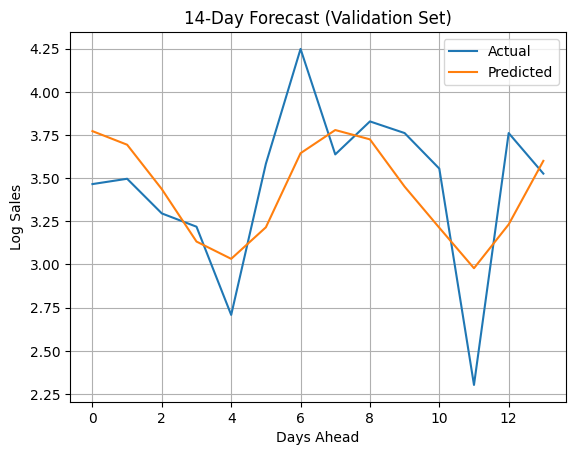

In [13]:
# --- Plot sample forecast ---
plt.plot(range(14), y_val[0], label="Actual")
plt.plot(range(14), y_pred[0], label="Predicted")
plt.title("14-Day Forecast (Validation Set)")
plt.xlabel("Days Ahead")
plt.ylabel("Log Sales")
plt.legend()
plt.grid(True)
plt.show()

In this project, I built a deep learning model to forecast future product demand using historical ERP sales data. I worked with the Favorita grocery dataset and narrowed the focus to a high-selling item at a single store to create a clean and reliable time series. From there, I added key features like day of the week, month, weekend indicators, and promotion flags to give the model more context behind why demand might change.

Using this data, I trained a bidirectional LSTM to predict the next 14 days of log-transformed sales. On the validation set, the model reached a RMSE of 0.5143 and a MAE of 0.3702, which is solid performance considering how unpredictable sales behavior can be.

Overall, this is a great example of how deep learning can be applied to real business problems inside ERP systems. Forecasting demand accurately helps businesses stay stocked without overstocking, manage costs, and plan better across the supply chain. With the right data and modeling approach, deep learning can really outperform traditional forecasting methods—especially in fast-moving environments like retail.